# Homework 1: Monty Hall
## Imports

In [1]:
using Random
using StatsBase

## User Settings

In [2]:
dev_mode = true
num_sims = 1000
num_doors = 3;

## Data Structures

In [3]:
door_options = Set{Symbol}([:goat, :car])

mutable struct Door
    open::Bool
    contains::Symbol
    
    function Door(open, contains)
        if !(contains in door_options)
            error("That is not a valid door option.")
        end
        new(open, contains)
    end
end

if dev_mode
    # these tests are because I'm new at julia and don't want to do anything 
    # too dumb
    d = Door(false, :goat)
    
    # make sure door initializes as planned
    @assert !d.open
    @assert d.contains == :goat
    
    # make sure door is properly mutable
    d.open = true
    @assert d.open
    d.contains = :car
    @assert d.contains == :car
end

## Functions

### `pick_a_door_at_random()`
Write a `function pick_a_door_at_random()` that returns an integer in {1, 2, 3} at random, representing the door that the contestant chose at random.

In [4]:
function pick_a_door_at_random()
    return rand(1:num_doors)
end;

### `set_up_doors()`
Write a `function set_up_doors()` that constructs and returns an Array of three `Door`s`(Array{Door})` **(line 16)** such that:
* [x] two doors have a goat behind them **(line 17)**
* [x] one door has a car behind it **(line 18)**
* [x] which door has the car is chosen at uniform random **(check histogram from line 13)**
* [x] all doors are unopened **(line 19)**


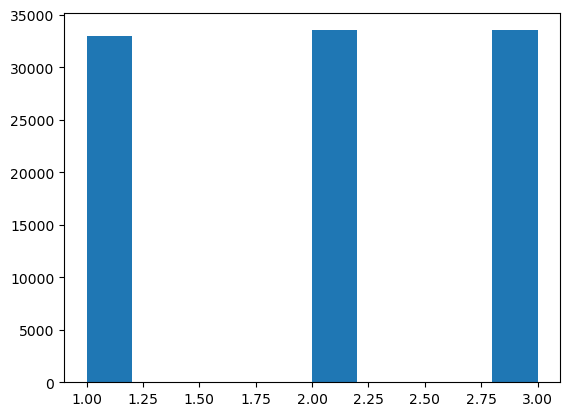

In [5]:
function set_up_doors()
    doors = [Door(false, :goat) for _ in 1:num_doors]
    doors[pick_a_door_at_random()].contains = :car
    return doors
end

if dev_mode
    using PyPlot
    test = [NaN for _ in 1:100000]
    for i in 1:length(test)
        test[i] = pick_a_door_at_random()
    end
    hist(test)
    
    doors = set_up_doors()
    @assert doors isa Array{Door}
    @assert length(doors) == 3
    @assert sum([d.contains == :car for d in doors]) == 1
    @assert !any([d.open for d in doors])
end

### `open_a_door!()`
Write a `function open_a_door!(doors::Array{Door}, first_door_id_pick::Int)`
that opens one of the `Door`s passed to it such that:
* [x] the door that the contestant picked, `first_door_id_pick`, is not opened **(line 21)**
* [x] the door with the car is not opened **(line 22)**
* [x] if two doors are viable to open, pick one at uniform random **(line 11; no assertion)**

In [6]:
function open_a_door!(doors::Array{Door}, first_door_id_pick::Int)
    valid_doors = Array{Int}(1:num_doors)
    if !(first_door_id_pick in valid_doors)
        error("That isn't even a valid door, dude.")
    end
    deleteat!(valid_doors, valid_doors .== first_door_id_pick)
    deleteat!(valid_doors, [doors[i].contains == :car for i in valid_doors])
    if length(valid_doors) == 1
        doors[valid_doors[1]].open = true
    else
        doors[rand(valid_doors)].open = true
    end
    
end

if dev_mode
    for _ in 1:10000
        doors = set_up_doors()
        first_pick = pick_a_door_at_random()
        open_a_door!(doors, first_pick)
        @assert !doors[first_pick].open
        @assert !doors[[d.contains == :car for d in doors]][1].open
    end
end

### `switch_door_pick()`
Write a `function switch_door_pick(doors::Array{Door}, first_door_id_pick::Int64)` that returns the index in {1, 2, 3} of the door that the contestant must pick if he/she switches from his/her initial door choice to the other unopened door. It is assumed in this function that one the Doors passed has been opened by the game host and has a goat behind it.

In [7]:
function switch_door_pick(doors::Array{Door}, first_door_id_pick::Int64)
    # this could be done without rand, but it's here anyways in case I ever 
    # feel like using a non-3 number of doors for some reason
    if !any([d.open for d in doors])
        error("Host hasn't opened a door")
    end
    
    selectable_doors = Array{Int}(1:num_doors)
    deleteat!(selectable_doors, [d.open for d in doors])
    return rand(selectable_doors[selectable_doors .!= first_door_id_pick])
end

if dev_mode
    good_doors = Array{Int}(1:num_doors)
    for _ in 1:10000
        doors = set_up_doors()
        first_pick = pick_a_door_at_random()
        open_a_door!(doors, first_pick)
        new_door = switch_door_pick(doors, first_pick)
        @assert !(new_door == first_pick)
        @assert !doors[new_door].open
        @assert new_door in good_doors
    end
end

### `contestant_wins_car()`
Write a `function contestant_wins_car(doors::Array{Door}, door_id_pick::Int)` that returns 'true' if the contestant picked the door with the car behind it and 'false' otherwise.

In [8]:
function contestant_wins_car(doors::Array{Door}, door_id_pick::Int64)
    if doors[door_id_pick].contains == :car
        return true
    else
        return false
    end
end

if dev_mode
    doors = set_up_doors()
    for (i, d) in enumerate(doors)
        if d.contains == :car
            @assert contestant_wins_car(doors, i)
        else
            @assert !contestant_wins_car(doors, i)
        end
    end
end

### `simulate_Monte_Hall()`
Write a `function simulate_Monte_Hall(switch::Bool; verbose::Bool=true)` that uses all of the functions above to simulate one Monte Hall game, and returns `true` if the contestant won and `false` otherwise. The `switch` argument specifies whether the
contestant uses the strategy to switch doors. The `verbose` argument specifies whether the function (for debugging and illustration) prints off details of the outcome including 
* [x] what is behind each door **(line 16)**
* [x] what door the contestant picks **(line 20)**, 
* [x] what door the game show host opened to reveal a goat **(line 21)**,
* [x] (if applicable) the choice of the door after the contestant switches **(line 23)**, and 
* [x] finally, if the contestant won or lost **(line 27)**.

In [9]:
win_or_lose = Dict{Bool, String}(true => "wins! :)", false => "loses. :(")

function simulate_Monte_Hall(switch::Bool; verbose::Bool=true)
    doors = set_up_doors()
    first_pick = pick_a_door_at_random()
    open_a_door!(doors, first_pick)
    if switch
        second_pick = switch_door_pick(doors, first_pick)
        outcome = contestant_wins_car(doors, second_pick)
    else
        outcome = contestant_wins_car(doors, first_pick)
    end
    
    if verbose
        for (i, d) in enumerate(doors)
            println("Door #", i, " is hiding a ", d.contains)
        end
        println()
        println("Begin Game...")
        println("Contestant initially chose door #", first_pick)
        println("Host chose door #", (1:num_doors)[[d.open for d in doors]][1])
        if switch
            print("Contestant switched to door #", second_pick)
        else
            print("Contestant keeps door #", first_pick)
        end
        println(" and ", win_or_lose[outcome])
    end
    return outcome
end

if dev_mode
    simulate_Monte_Hall(true)
end

Door #1 is hiding a car
Door #2 is hiding a goat
Door #3 is hiding a goat

Begin Game...
Contestant initially chose door #3
Host chose door #2
Contestant switched to door #1 and wins! :)


true

## Simulation
Run 1000 simulations of the Monte Hall problem under the two strategies. Print off how many times the contestant won under both of the strategies.

In [10]:
strategies = Dict{Bool, String}(
    true => "changing doors",
    false => "keeping the first door"
)
victories = Dict{Bool, Int}(
    true => 0, 
    false => 0
)
num_switches = length(strategies)
for _ in 1:num_sims
    for switch in keys(victories)
        victories[switch] += simulate_Monte_Hall(
            switch,
            verbose=false
        )
    end
end

print("In this simulation there were")
for (i, switch) in enumerate(keys(victories))
    num_victories = victories[switch]
    percent = 100. * Float64(num_victories) / Float64(num_sims)
    strategy = strategies[switch]
    print(" $num_victories victories ($percent%) from $strategy")
    if i < num_switches
        print(" and")
    else
        print(".")
    end
end

In this simulation there were 356 victories (35.6%) from keeping the first door and 688 victories (68.8%) from changing doors.